In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

In [2]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

In [3]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [4]:
# In the original dataset, `'AdoptionSpeed'` of `4` indicates
# a pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop unused features.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

In [5]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [6]:
print(f"New dimensions of split data: 1. train data = {train.shape}, 2. test data = {test.shape} and 3. val data = {val.shape}")

New dimensions of split data: 1. train data = (9229, 14), 2. test data = (1154, 14) and 3. val data = (1154, 14)


In [7]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [8]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

2021-11-03 14:43:50.884276: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor([ 4 12  2  6  2], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([1 1 1 1 0], shape=(5,), dtype=int64)


## Preprocess Numerical Cols

In [10]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

## Preprocess Categorical and Integer Cols

In [11]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [12]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [13]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

2021-11-03 14:43:55.104497: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [14]:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [15]:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [16]:
all_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'PhotoAmt')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Fee')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'Age')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Type')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Color1')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Color2')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Gender')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'MaturitySize')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'FurLength')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Vaccinated')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Sterilized')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Health')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Breed1')>]

In [17]:
encoded_features

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_1')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_2')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_3')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_4')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_5')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_6')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_7')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_8')>,
 <KerasTensor: shape=(None, 4) dtype=float32

In [18]:
[(train_features, label_batch)] = val_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Gender'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor(
[b'Male' b'Female' b'Female' b'Male' b'Male' b'Male' b'Female' b'Female'
 b'Male' b'Female' b'Male' b'Female' b'Female' b'Female' b'Female'
 b'Female' b'Male' b'Female' b'Male' b'Female' b'Female' b'Female'
 b'Female' b'Male' b'Male' b'Female' b'Male' b'Female' b'Female' b'Male'
 b'Female' b'Female' b'Male' b'Male' b'Male' b'Male' b'Male' b'Female'
 b'Female' b'Male' b'Female' b'Male' b'Female' b'Female' b'Male' b'Male'
 b'Male' b'Male' b'Male' b'Female' b'Female' b'Male' b'Male' b'Female'
 b'Female' b'Male' b'Female' b'Male' b'Male' b'Female' b'Female' b'Female'
 b'Female' b'Female' b'Male' b'Female' b'Male' b'Female' b'Male' b'Female'
 b'Male' b'Male' b'Female' b'Female' b'Female' b'Female' b'Male' b'Female'
 b'Female' b'Female' b'Male' b'Male' b'Male' b'Female' b'Male' b'Female'
 b'Male' b'Female' b'F

In [19]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

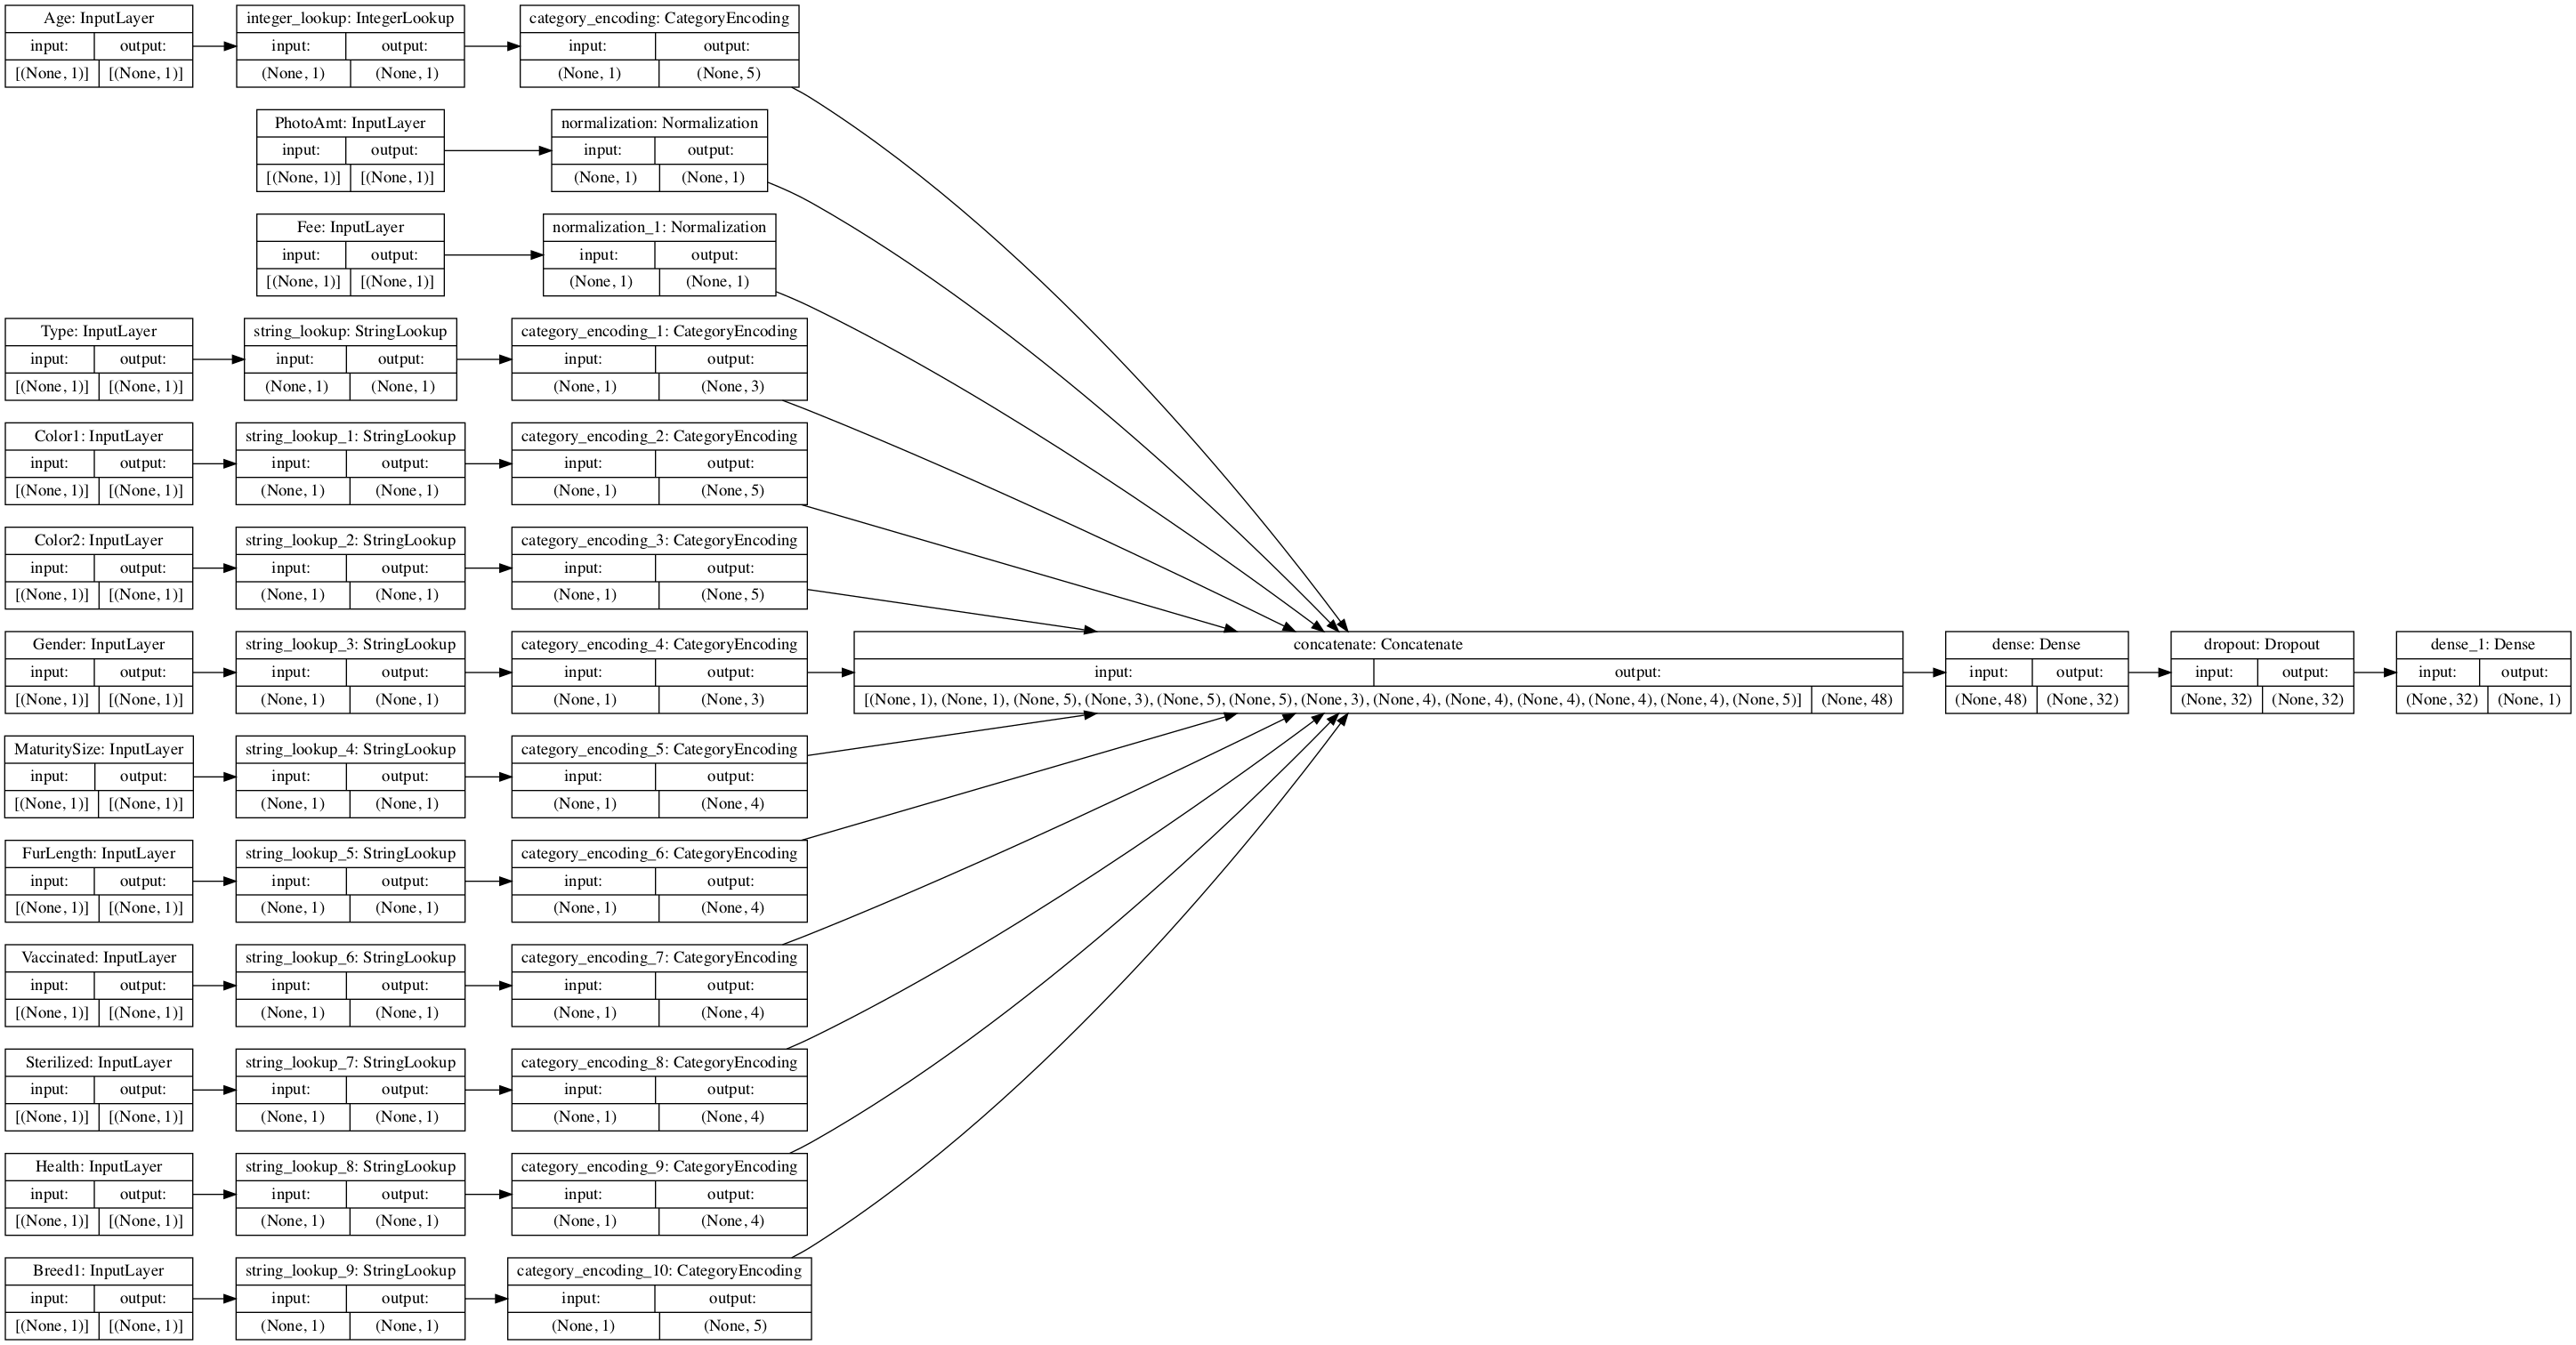

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [22]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
37/37 [==============================] - 1s 12ms/step - loss: 0.6371 - accuracy: 0.5229 - val_loss: 0.5590 - val_accuracy: 0.7288
Epoch 2/10
37/37 [==============================] - 0s 2ms/step - loss: 0.5823 - accuracy: 0.6603 - val_loss: 0.5367 - val_accuracy: 0.7288
Epoch 3/10
37/37 [==============================] - 0s 2ms/step - loss: 0.5657 - accuracy: 0.6895 - val_loss: 0.5258 - val_accuracy: 0.7392
Epoch 4/10
37/37 [==============================] - 0s 2ms/step - loss: 0.5515 - accuracy: 0.6998 - val_loss: 0.5184 - val_accuracy: 0.7435
Epoch 5/10
37/37 [==============================] - 0s 2ms/step - loss: 0.5437 - accuracy: 0.7137 - val_loss: 0.5129 - val_accuracy: 0.7444
Epoch 6/10
37/37 [==============================] - 0s 2ms/step - loss: 0.5372 - accuracy: 0.7216 - val_loss: 0.5084 - val_accuracy: 0.7470
Epoch 7/10
37/37 [==============================] - 0s 2ms/step - loss: 0.5336 - accuracy: 0.7194 - val_loss: 0.5052 - val_accuracy: 0.7513
Epoch 8/10
37/37 [=

In [23]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

5/5 [==============================] - 0s 1ms/step - loss: 0.5178 - accuracy: 0.7383
Accuracy 0.7383015751838684


In [24]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

This particular pet had a 83.8 percent probability of getting adopted.


In [25]:
sample = {
    'Type': 'Dragon',
    'Age': 100,
    'Breed1': 'Komodo',
    'Gender': 'None',
    'Color1': 'Black',
    'Color2': 'Black',
    'MaturitySize': 'Large',
    'FurLength': 'Scales',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Unknown',
    'Fee': 100,
    'PhotoAmt': 1,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

This particular pet had a 67.4 percent probability of getting adopted.


In [26]:
list(train_ds.skip(5).take(1).as_numpy_iterator())

[({'Type': array([b'Dog', b'Dog', b'Dog', b'Dog', b'Dog', b'Dog', b'Cat', b'Dog',
          b'Cat', b'Dog', b'Cat', b'Dog', b'Cat', b'Dog', b'Dog', b'Dog',
          b'Dog', b'Dog', b'Dog', b'Cat', b'Dog', b'Cat', b'Dog', b'Cat',
          b'Dog', b'Cat', b'Cat', b'Dog', b'Cat', b'Dog', b'Cat', b'Cat',
          b'Dog', b'Dog', b'Cat', b'Dog', b'Cat', b'Cat', b'Dog', b'Dog',
          b'Cat', b'Cat', b'Cat', b'Cat', b'Dog', b'Cat', b'Cat', b'Dog',
          b'Dog', b'Dog', b'Dog', b'Dog', b'Dog', b'Cat', b'Dog', b'Cat',
          b'Dog', b'Dog', b'Cat', b'Cat', b'Cat', b'Dog', b'Cat', b'Dog',
          b'Dog', b'Dog', b'Dog', b'Cat', b'Cat', b'Dog', b'Cat', b'Dog',
          b'Dog', b'Cat', b'Cat', b'Cat', b'Cat', b'Dog', b'Dog', b'Dog',
          b'Cat', b'Cat', b'Dog', b'Dog', b'Dog', b'Cat', b'Dog', b'Cat',
          b'Cat', b'Cat', b'Dog', b'Dog', b'Dog', b'Cat', b'Dog', b'Dog',
          b'Dog', b'Cat', b'Dog', b'Dog', b'Dog', b'Cat', b'Dog', b'Cat',
          b'Dog', b'Cat', b'Ca

In [27]:
for item in val_ds:
    print(item)

({'Type': <tf.Tensor: shape=(256,), dtype=string, numpy=
array([b'Dog', b'Cat', b'Dog', b'Cat', b'Dog', b'Dog', b'Cat', b'Dog',
       b'Dog', b'Cat', b'Dog', b'Cat', b'Dog', b'Dog', b'Dog', b'Cat',
       b'Dog', b'Cat', b'Cat', b'Dog', b'Dog', b'Dog', b'Dog', b'Dog',
       b'Cat', b'Dog', b'Dog', b'Cat', b'Dog', b'Dog', b'Dog', b'Dog',
       b'Cat', b'Cat', b'Dog', b'Cat', b'Cat', b'Dog', b'Cat', b'Dog',
       b'Dog', b'Dog', b'Dog', b'Dog', b'Dog', b'Cat', b'Cat', b'Dog',
       b'Cat', b'Dog', b'Cat', b'Cat', b'Dog', b'Dog', b'Dog', b'Dog',
       b'Dog', b'Dog', b'Dog', b'Cat', b'Dog', b'Dog', b'Dog', b'Dog',
       b'Dog', b'Cat', b'Cat', b'Cat', b'Cat', b'Dog', b'Cat', b'Cat',
       b'Dog', b'Cat', b'Cat', b'Dog', b'Cat', b'Cat', b'Dog', b'Cat',
       b'Dog', b'Dog', b'Dog', b'Cat', b'Dog', b'Dog', b'Dog', b'Cat',
       b'Dog', b'Cat', b'Cat', b'Dog', b'Cat', b'Cat', b'Dog', b'Cat',
       b'Dog', b'Dog', b'Cat', b'Cat', b'Dog', b'Dog', b'Dog', b'Dog',
       b'Dog', b'Dog